## MSM.jl and Surrogates.jl

This notebook shows how one can estimate a model using [MSM.jl](https://github.com/JulienPascal/MSM.jl) and [Surrogates.jl](https://github.com/SciML/Surrogates.jl)

In [1]:
using MSM
using Surrogates
using DataStructures
using OrderedCollections
using Distributions
using Random
using DataStructures
using Statistics
using LinearAlgebra

Random.seed!(1234)  #for replicability reasons
T = 100000          #number of periods
P = 2               #number of dependent variables
beta0 = rand(P)     #choose true coefficients by drawing from a uniform distribution on [0,1]
alpha0 = rand(1)[]  #intercept
theta0 = 0.0        #coefficient to create serial correlation in the error terms
println("True intercept = $(alpha0)")
println("True coefficient beta0 = $(beta0)")
println("Serial correlation coefficient theta0 = $(theta0)")

# Generation of error terms
# row = individual dimension
# column = time dimension 
U = zeros(T)
d = Normal()
U[1] = rand(d, 1)[] #first error term
# loop over time periods
for t = 2:T
    U[t] = rand(d, 1)[] + theta0*U[t-1]
end

# Let's simulate the dependent variables x_t
x = zeros(T, P)

d = Uniform(0, 5)
for p = 1:P  
    x[:,p] = rand(d, T)
end

# Let's calculate the resulting y_t
y = zeros(T)

for t=1:T
    y[t] = alpha0 + x[t,1]*beta0[1] + x[t,2]*beta0[2] + U[t]
end

optionsSMM = MSMOptions(maxFuncEvals=1000, globalOptimizer = :dxnes, localOptimizer = :NelderMead)
myProblem = MSMProblem(options = optionsSMM);

# Priors
dictPriors = OrderedDict{String,Array{Float64,1}}()
dictPriors["alpha"] = [0.5, 0.001, 1.0]
dictPriors["beta1"] = [0.5, 0.001, 1.0]
dictPriors["beta2"] = [0.5, 0.001, 1.0]
set_priors!(myProblem, dictPriors)

# Empirical moments
dictEmpiricalMoments = OrderedDict{String,Array{Float64,1}}()
dictEmpiricalMoments["mean"] = [mean(y); mean(y)] #informative on the intercept
dictEmpiricalMoments["mean_x1y"] = [mean(x[:,1] .* y); mean(x[:,1] .* y)] #informative on betas
dictEmpiricalMoments["mean_x2y"] = [mean(x[:,2] .* y); mean(x[:,2] .* y)] #informative on betas
dictEmpiricalMoments["mean_x1y^2"] = [mean((x[:,1] .* y).^2); mean((x[:,1] .* y).^2)] #informative on betas
dictEmpiricalMoments["mean_x2y^2"] = [mean((x[:,2] .* y).^2); mean((x[:,2] .* y).^2)] #informative on betas
set_empirical_moments!(myProblem, dictEmpiricalMoments)


# x[1] corresponds to the intercept, x[2] corresponds to beta1, x[3] corresponds to beta2
function functionLinearModel(x; uniform_draws::Array{Float64,1}, simX::Array{Float64,2}, nbDraws::Int64 = length(uniform_draws), burnInPerc::Int64 = 10)
    T = nbDraws
    P = 2       #number of dependent variables

    alpha = x[1]
    beta = x[2:end]
    theta = 0.0     #coefficient to create serial correlation in the error terms

    # Creation of error terms
    # row = individual dimension
    # column = time dimension
    U = zeros(T)
    d = Normal()
    # Inverse cdf (i.e. quantile)
    gaussian_draws = quantile.(d, uniform_draws)
    U[1] = gaussian_draws[1] #first error term

    # loop over time periods
    for t = 2:T
        U[t] = gaussian_draws[t] + theta*U[t-1]
    end

    # Let's calculate the resulting y_t
    y = zeros(T)

    for t=1:T
        y[t] = alpha + simX[t,1]*beta[1] + simX[t,2]*beta[2] + U[t]
    end

    # Get rid of the burn-in phase:
    #------------------------------
    startT = div(nbDraws, burnInPerc)

    # Moments:
    #---------
    output = OrderedDict{String,Float64}()
    output["mean"] = mean(y[startT:nbDraws])
    output["mean_x1y"] = mean(simX[startT:nbDraws,1] .* y[startT:nbDraws])
    output["mean_x2y"] = mean(simX[startT:nbDraws,2] .* y[startT:nbDraws])
    output["mean_x1y^2"] = mean((simX[startT:nbDraws,1] .* y[startT:nbDraws]).^2)
    output["mean_x2y^2"] = mean((simX[startT:nbDraws,2] .* y[startT:nbDraws]).^2)

    return output
end

# Let's freeze the randomness during the minimization
d_Uni = Uniform(0,1)
nbDraws = 100000 #number of draws in the simulated data
uniform_draws = rand(d_Uni, nbDraws)
simX = zeros(length(uniform_draws), 2)
d = Uniform(0, 5)
for p = 1:2
  simX[:,p] = rand(d, length(uniform_draws))
end

set_simulate_empirical_moments!(myProblem, x -> functionLinearModel(x, uniform_draws = uniform_draws, simX = simX))
construct_objective_function!(myProblem)

┌ Info: Precompiling MSM [553e158a-22df-4687-a16d-90d753ebe799]
└ @ Base loading.jl:1278


True intercept = 0.5662374165061859
True coefficient beta0 = [0.5908446386657102, 0.7667970365022592]
Serial correlation coefficient theta0 = 0.0


(::MSM.var"#objective_function_percent#6"{MSMProblem}) (generic function with 1 method)

In [2]:
myProblem.objective_function([dictPriors[k][1] for k in keys(dictPriors)])

0.1028934456464878

### Sampling

In [3]:
n_samples = 50
lower_bound = create_lower_bound(myProblem)
upper_bound = create_upper_bound(myProblem)

xys = Surrogates.sample(n_samples, lower_bound, upper_bound, SobolSample());
size(xys)

(50,)

In [4]:
g(x) = myProblem.objective_function(x)
zs = g.(xys);
size(zs)

(50,)

### Building a surrogate

In [5]:
kriging_surrogate = Kriging(xys, zs, lower_bound, upper_bound, p=[1.9, 1.9, 1.9]);

### Optimizing

In [6]:
@time surrogate_optimize(g, SRBF(), lower_bound, upper_bound, kriging_surrogate, SobolSample(), maxiters=20)

Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Krigin

Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Kriging.
Adding a sample that already exists, cannot build Krigin

((0.5757326756315339, 0.5833677440466595, 0.7654161011090741), 7.080259409909588e-7)

In [7]:
size(xys)

(211,)

In [8]:
println("True intercept = $(alpha0)")
println("True coefficient beta0 = $(beta0)")

True intercept = 0.5662374165061859
True coefficient beta0 = [0.5908446386657102, 0.7667970365022592]


### Plotting the surrogate

Let's plot the objective function, **holding constant the value of $\alpha$**:

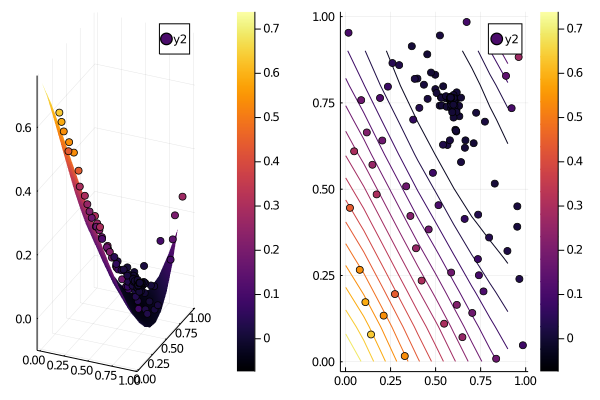

In [9]:
using Plots
gr()
p1 = plot(collect(lower_bound[2]:0.1:upper_bound[2]), collect(lower_bound[3]:0.1:upper_bound[3]), (x, y) -> kriging_surrogate([alpha0 x y]), linetype=:surface)
xs = [xy[2] for xy in xys]
ys = [xy[3] for xy in xys]
gg(x) = g([alpha0; x[2]; x[3]])
zs = gg.(xys) 
scatter!(xs, ys, zs, marker_z=zs)
p2 = contour(collect(lower_bound[2]:0.1:upper_bound[2]), collect(lower_bound[3]:0.1:upper_bound[3]), (x, y) -> kriging_surrogate([alpha0 x y]))
scatter!(xs, ys, marker_z=zs) # hide
plot(p1, p2) # hide

Let's plot the objective function, **holding constant the value of $\beta_2$**:

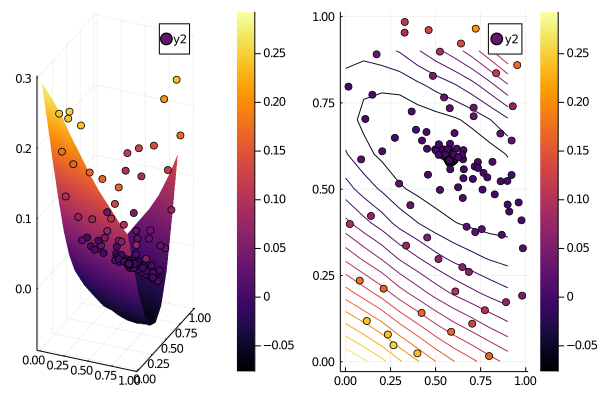

In [10]:
p1 = plot(collect(lower_bound[1]:0.1:upper_bound[1]), collect(lower_bound[2]:0.1:upper_bound[2]), (x, y) -> kriging_surrogate([x y beta0[2]]), linetype=:surface)
xs = [xy[1] for xy in xys]
ys = [xy[2] for xy in xys]
gg(x) = g([x[1]; x[2]; beta0[2]])
zs = gg.(xys) 
scatter!(xs, ys, zs, marker_z=zs)
p2 = contour(collect(lower_bound[1]:0.1:upper_bound[1]), collect(lower_bound[2]:0.1:upper_bound[2]), (x, y) -> kriging_surrogate([x y beta0[2]]))
scatter!(xs, ys, marker_z=zs) # hide
plot(p1, p2) # hide

In [11]:
versioninfo()

Julia Version 1.5.1
Commit 697e782ab8 (2020-08-25 20:08 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)
